In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_processing
sns.set()
pd.set_option('display.max_columns', 60)

# Looking our data

In [ ]:
train_source, train_target, test_source = data_processing.preprocess_data()

In [ ]:
train_source.head()

,user_id,device_id,session_id,title_id,event_time,played_duration,action_trigger,platform,title_in_simulcast,internet_connection_type,weekday,date,time,time_category
0,0,525,2328,384,2022-04-03 09:36:30,1361,1,0,0,1,7,2022-04-03,09:36:30,3rd 9h~17h
1,0,525,2328,384,2022-04-03 09:36:35,2,0,0,0,1,7,2022-04-03,09:36:35,3rd 9h~17h
2,0,525,2400,68,2022-04-03 10:06:01,2,0,0,0,1,7,2022-04-03,10:06:01,3rd 9h~17h
3,0,525,2400,68,2022-04-03 10:06:36,20,9,0,0,1,7,2022-04-03,10:06:36,3rd 9h~17h
4,0,532,2401,68,2022-04-03 10:07:04,8,10,2,1,4,7,2022-04-03,10:07:04,3rd 9h~17h


# Descriptive statistics & EDA

In [ ]:
train_total_duration = train_source.groupby('user_id')['played_duration'].sum() / 3600
test_total_duration = test_source.groupby('user_id')['played_duration'].sum() / 3600
total_duration = pd.concat([train_total_duration.describe(), test_total_duration.describe()], axis=1)
total_duration.columns = ['Train', 'Test']
round(total_duration,2)

,Train,Test
count,30460.00,7616.00
mean,85.24,84.54
std,105.31,108.28
min,0.00,0.00
25%,23.76,21.95
50%,56.70,54.71
75%,111.21,108.22
max,3332.20,2298.29


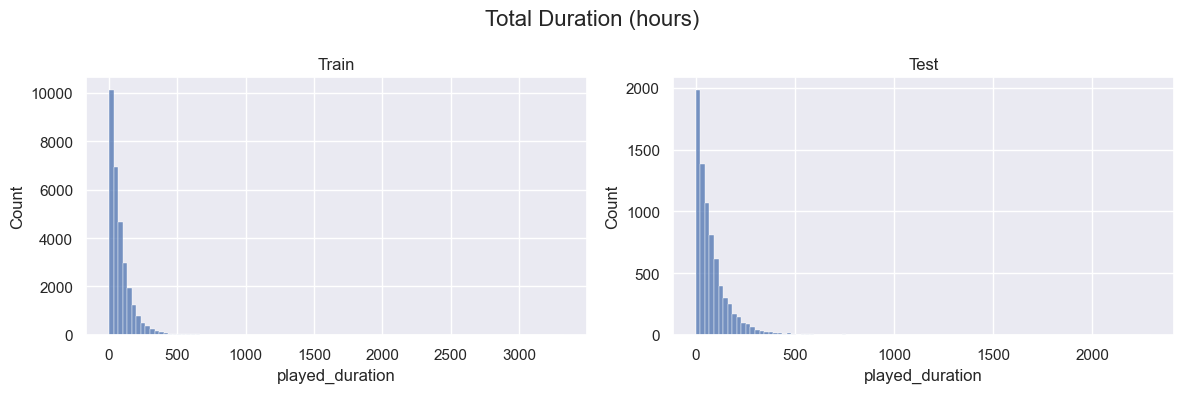

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train_total_duration, bins=100, ax=axes[0])
sns.histplot(test_total_duration, bins=100, ax=axes[1])
axes[0].set_title('Train')
axes[1].set_title('Test')
fig.suptitle('Total Duration (hours)', fontsize=16)
plt.tight_layout()

In [ ]:
train_num_title = train_source.groupby('user_id')['title_id'].nunique()
test_num_title = test_source.groupby('user_id')['title_id'].nunique()
total_num_title = pd.concat([train_num_title.describe(),test_num_title.describe()], axis=1)
total_num_title.columns = ['Train', 'Test']
round(total_num_title,2)

,Train,Test
count,30460.00,7616.00
mean,35.92,35.24
std,33.08,32.66
min,1.00,1.00
25%,13.00,13.00
50%,28.00,27.00
75%,48.00,47.00
max,668.00,425.00


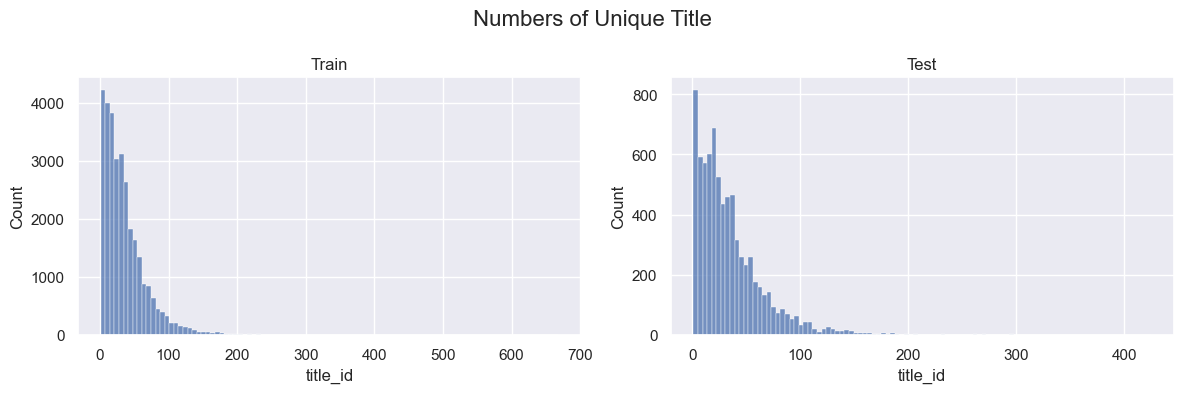

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#sns.histplot(train_num_title, bins=100, ax=axes[0])
#sns.histplot(test_num_title, bins=100, ax=axes[1])
sns.boxplot(train_num_title, )
axes[0].set_title('Train')
axes[1].set_title('Test')
fig.suptitle('Numbers of Unique Title', fontsize=16)
plt.tight_layout()

# Diiferent time_category

In [ ]:
def user_time_category_(df):
    #計算用戶在各時段的觀看時間
    data_time = df.groupby(['user_id', 'time_category'])['played_duration'].sum().unstack().fillna(0)
    #將觀看時間轉換成小時
    df = data_time/3600
    return df

train_source_tc = user_time_category_(train_source)
train_target_tc = user_time_category_(train_target)
test_source_tc = user_time_category_(test_source)

In [ ]:
#用戶觀看時間統計表(訓練)
round(train_source_tc.describe(),2)

time_category,1st 1h~5h,2nd 5h~9h,3rd 9h~17h,4th 17h~1h
count,30460.00,30460.00,30460.00,30460.00
mean,7.50,3.88,29.40,44.46
std,18.00,11.79,45.03,55.72
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,5.62,10.72
50%,1.75,0.60,16.36,28.03
75%,7.56,3.16,36.73,59.01
max,788.59,440.97,1441.60,1499.74


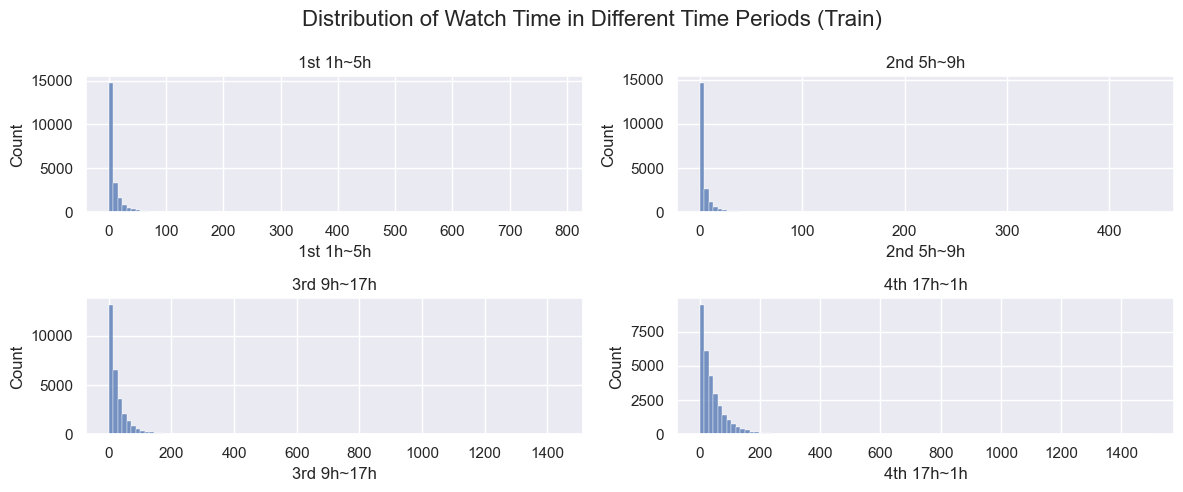

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# 遍歷欄位並繪製直方圖與 KDE
for idx, column in enumerate(train_source_tc.columns):
    ax = axes[idx // 2, idx % 2]  # 定位在 2x2 子圖中的位置
    sns.histplot(train_source_tc[column], bins=100, ax=ax)
    ax.set_title(f"{column}")
fig.suptitle('Distribution of Watch Time in Different Time Periods (Train)', fontsize=16)
plt.tight_layout()

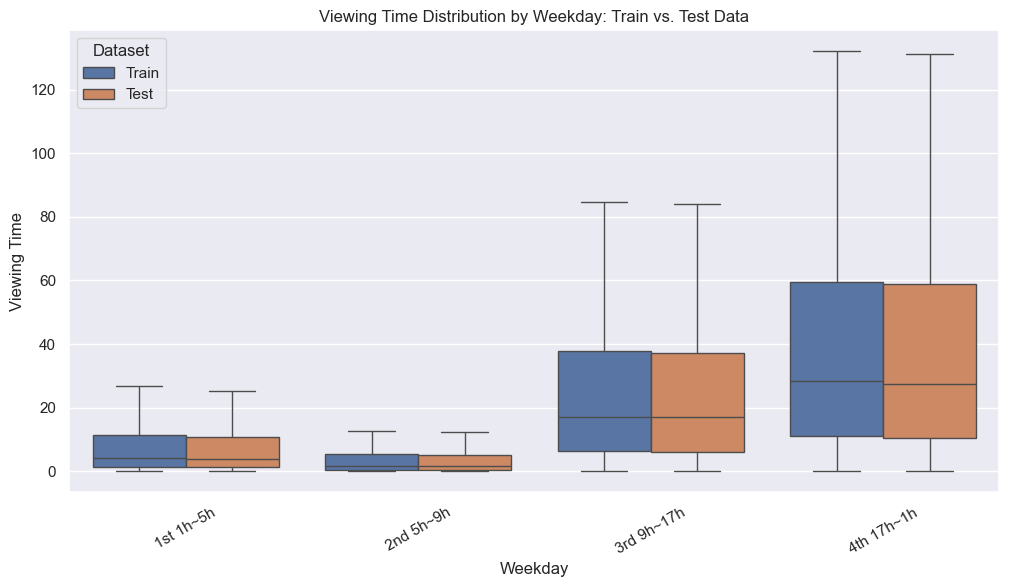

In [ ]:
def viewing_time_compare_plot(train_data, test_data):
    # 轉換數據為長格式並標記來源
    train_melted = train_data.melt(var_name="Feature", value_name="Value")
    train_melted["Source"] = "Train"

    test_melted = test_data.melt(var_name="Feature", value_name="Value")
    test_melted["Source"] = "Test"

    # 合併數據
    df_combined = pd.concat([train_melted, test_melted], ignore_index=True)

    # 設定圖表大小
    plt.figure(figsize=(12, 6))

    # 繪製 Boxplot，隱藏離群值
    sns.boxplot(x="Feature", y="Value", hue="Source", data=df_combined, showfliers=False)

    # 設定標題與標籤
    plt.xticks(rotation=30)
    plt.title("Viewing Time Distribution by Weekday: Train vs. Test Data")
    plt.xlabel("Weekday")
    plt.ylabel("Viewing Time")
    plt.legend(title="Dataset")

viewing_time_compare_plot(train_source_tc, test_source_tc)

# Different weekday

In [ ]:
def user_watch_time(data):
    #計算用戶在各時段的觀看時間
    df_time = data.groupby(['user_id', 'weekday'])['played_duration'].sum().unstack().fillna(0)
    #將觀看時間轉換成小時
    df = df_time/3600
    return df

train_source_wd = user_watch_time(train_source)
train_target_wd = user_watch_time(train_target)
test_source_wd = user_watch_time(test_source)

In [ ]:
#用戶觀看時間統計表
round(train_source_wd.describe().drop(["count", "min"]),2)

weekday,1,2,3,4,5,6,7
mean,11.99,11.48,11.41,11.03,10.91,13.56,14.86
std,16.67,15.73,17.35,15.40,15.27,18.07,19.48
25%,2.65,2.51,2.37,2.31,2.39,2.76,3.07
50%,7.56,7.17,6.95,6.79,6.72,8.08,9.02
75%,15.87,15.09,14.93,14.47,14.28,17.73,19.76
max,525.38,523.23,730.96,601.94,596.45,462.79,478.52


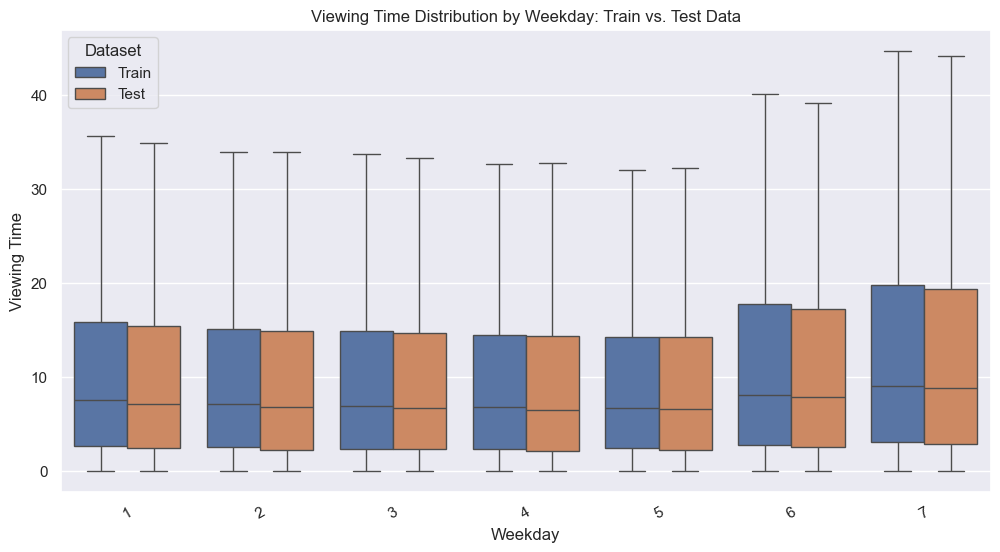

In [ ]:
viewing_time_compare_plot(train_source_wd, test_source_wd)

# Combine time_category and weekday

In [ ]:
def user_watch_time(data):
    #計算用戶在不同天各時段的觀看時間
    df_time = data.groupby(['user_id', 'time_category', 'weekday'])['played_duration'].sum().unstack().unstack().fillna(0)
    #將觀看時間轉換成小時
    df = df_time/3600
    return df

train_source_period = user_watch_time(train_source)
train_target_period = user_watch_time(train_target)
test_source_period = user_watch_time(test_source)

In [ ]:
train_source_period.mean().unstack()

time_category,1st 9h~17h,2nd 17h~1h,3rd 1h~5h,4th 5h~9h
weekday,,,,
1,3.808623,6.540828,1.103251,0.537645
2,3.676204,6.302660,0.989848,0.515070
3,3.603638,6.295795,0.992193,0.519298
4,3.553340,5.955074,0.999510,0.518443
5,3.740868,5.711830,0.942975,0.517053
6,5.340509,6.419268,1.154640,0.642654
7,5.679272,7.233884,1.316774,0.625618


In [18]:
train_source_period.quantile(0.75).unstack()

time_category,1st 9h~17h,2nd 17h~1h,3rd 1h~5h,4th 5h~9h
weekday,,,,
1,4.701389,8.776944,0.975347,0.275625
2,4.549583,8.477222,0.781458,0.253472
3,4.381667,8.311528,0.793681,0.246181
4,4.313611,7.944722,0.783125,0.238056
5,4.634306,7.632847,0.786389,0.283611
6,6.683750,8.612986,1.179653,0.411111
7,7.233472,9.745486,1.435972,0.382014


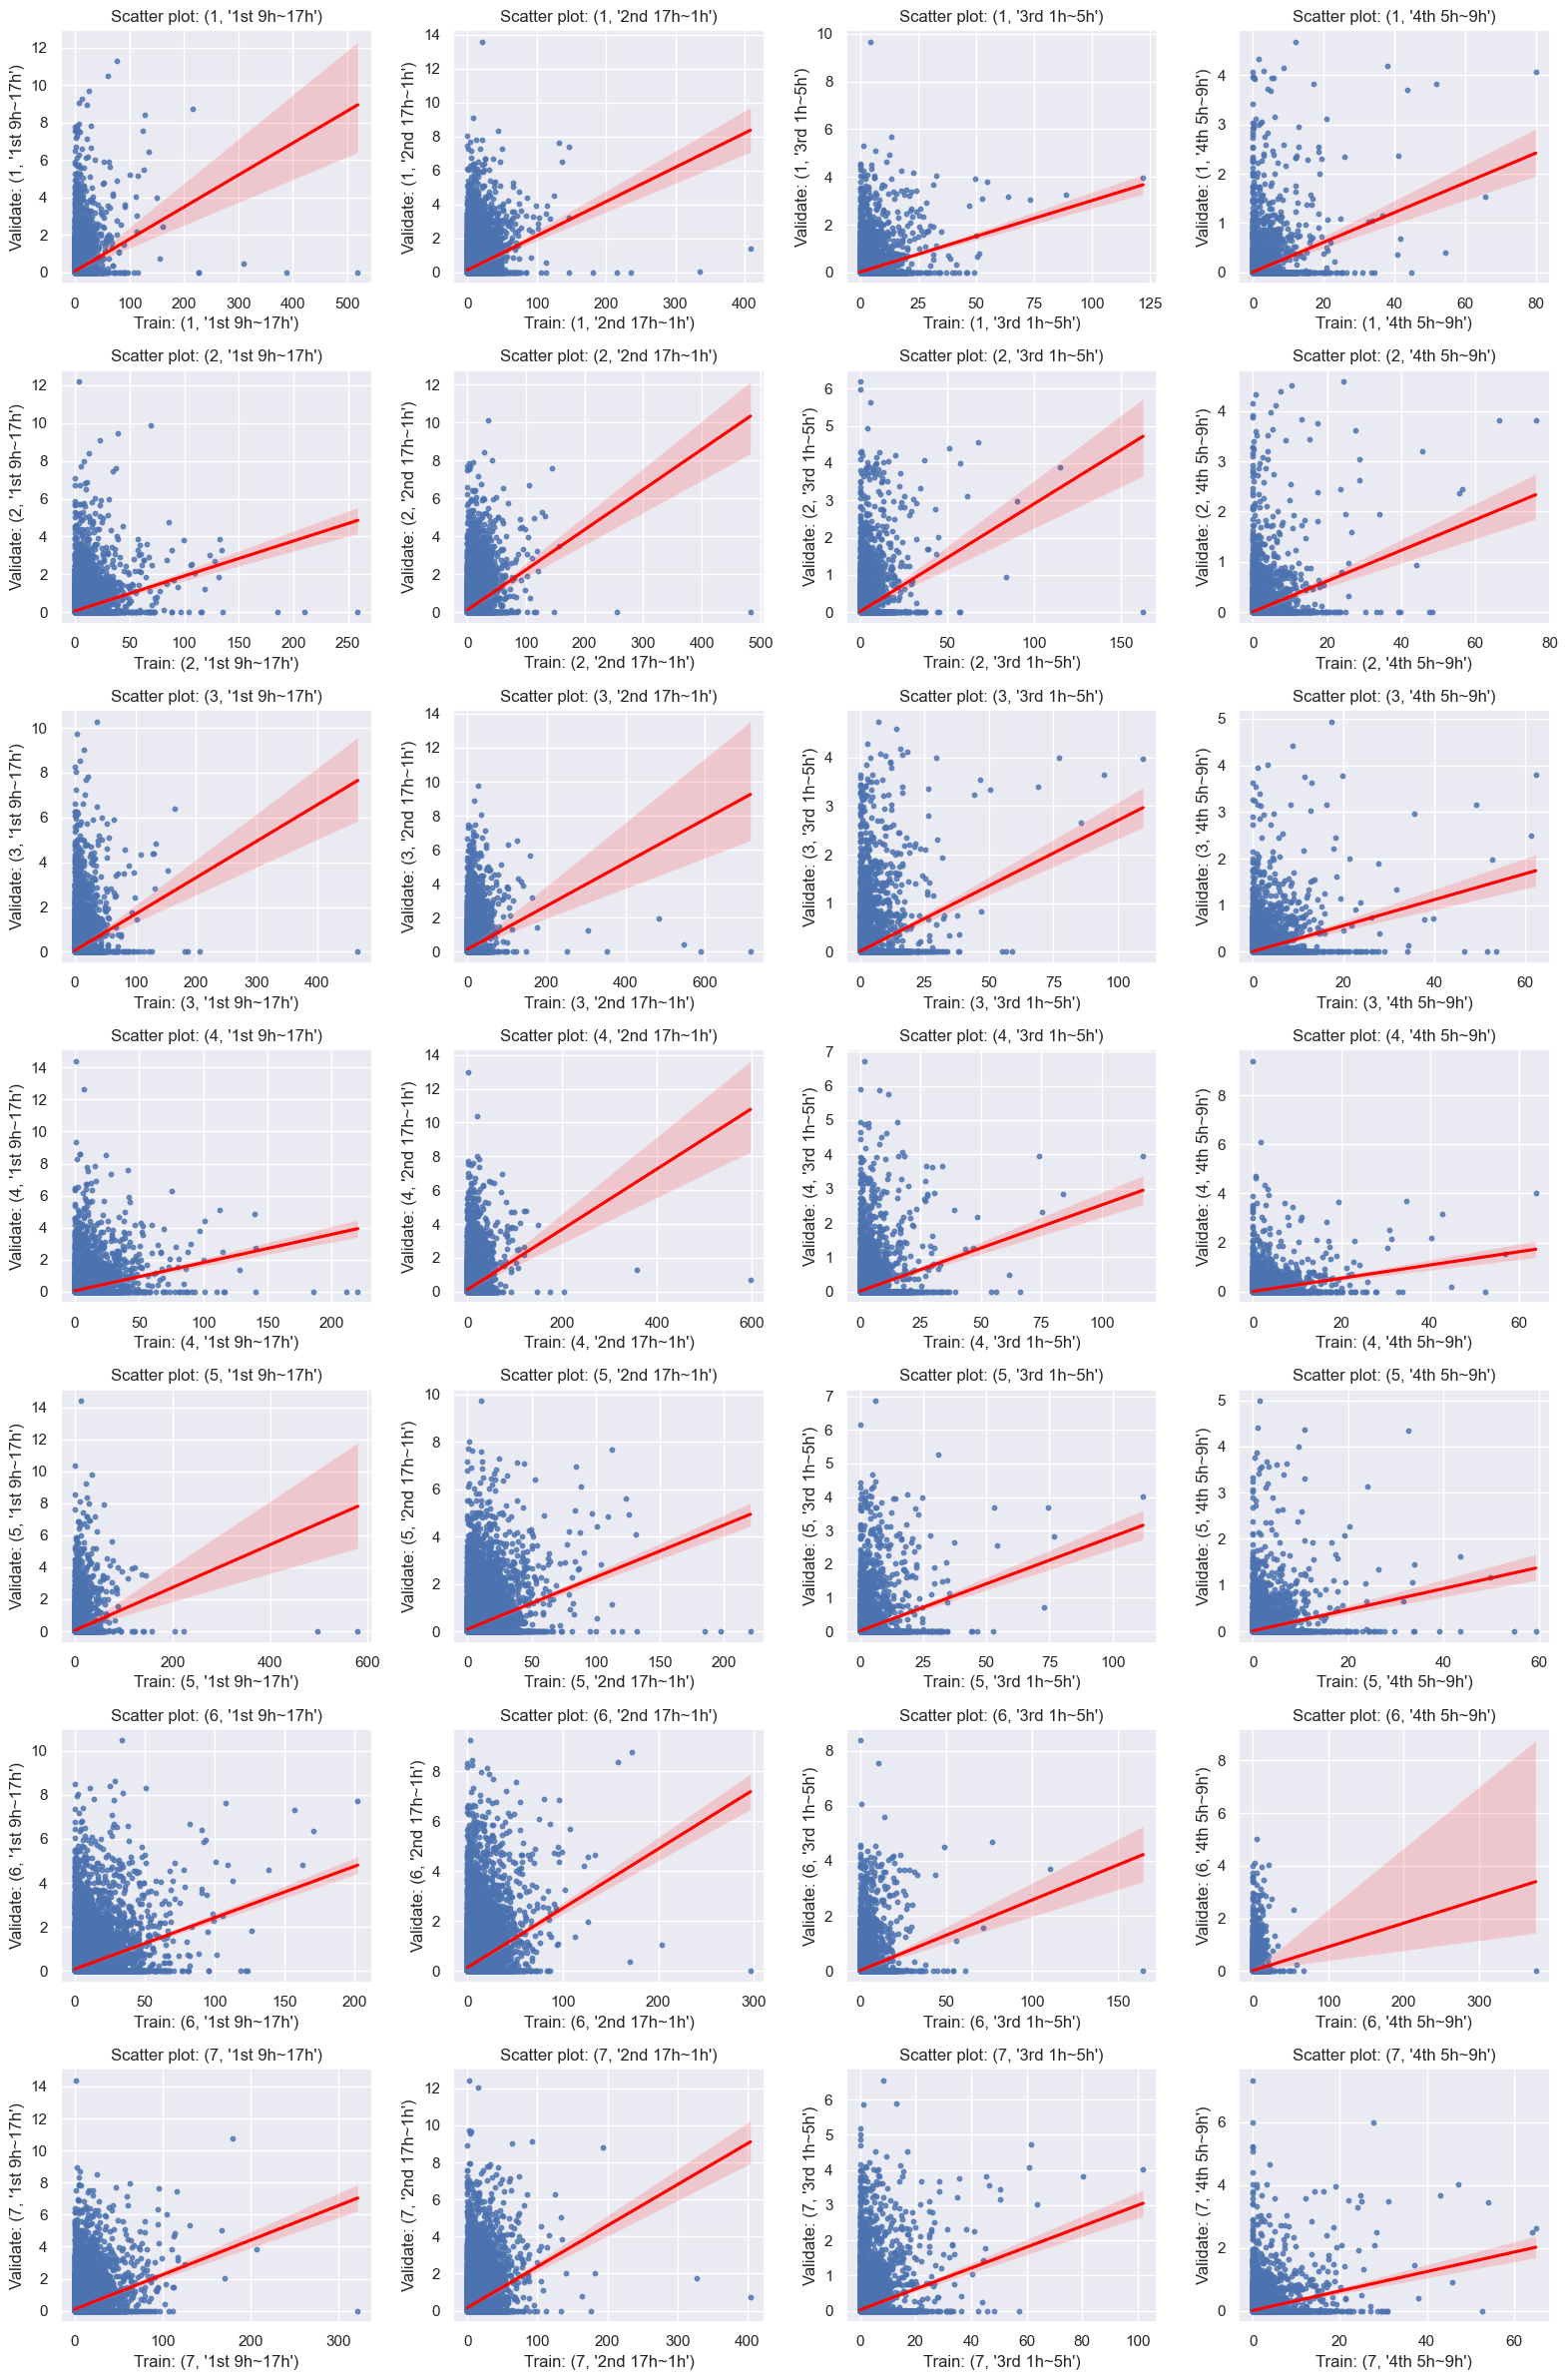

In [ ]:
columns = train_source_period.columns
num_cols = len(columns)

fig, axes = plt.subplots(7, 4, figsize=(16, 24))
axes = axes.flatten()

#遍歷欄位並繪製散佈圖
for i, col in enumerate(columns):
    #x = remove_outliers_iqr(train_source_period[col])
    x = train_source_period[col]
    y = train_target_period[col]
    sns.regplot(x=x,
                y=y.loc[x.index],
                ax=axes[i],
                scatter_kws={"s": 10},
                line_kws={"color": "red"})
    axes[i].set_xlabel(f'Train: {col}')
    axes[i].set_ylabel(f'Validate: {col}')
    axes[i].set_title(f'Scatter plot: {col}')

# 移除多餘的子圖（如果有）
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()